In [1]:
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
from typing import Optional
from typing import Tuple
import seaborn as sns
import numpy as np
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

pygame 2.5.2 (SDL 2.28.2, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


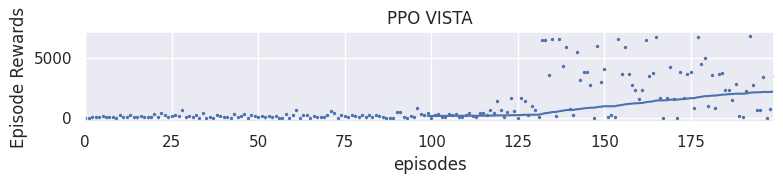

In [140]:
log_dir1 = "/mnt/persistent/lane-follow-ppo/tmp_7" # took 70 mins to train
log_dir2 = "/mnt/persistent/collision-avoidance-sac/tmp_2"
log_dir3 = "/mnt/persistent/collision-avoidance-sac/tmp_3"
log_dir3 = "/mnt/persistent/collision-avoidance-sac/tmp_4"
timesteps = 500_000
plot_results([
    log_dir1,
    # log_dir2,
    # log_dir3,
    # log_dir4
], timesteps, results_plotter.X_EPISODES, "PPO VISTA")
plt.show()

<Axes: xlabel='index', ylabel='course_completion_rate'>

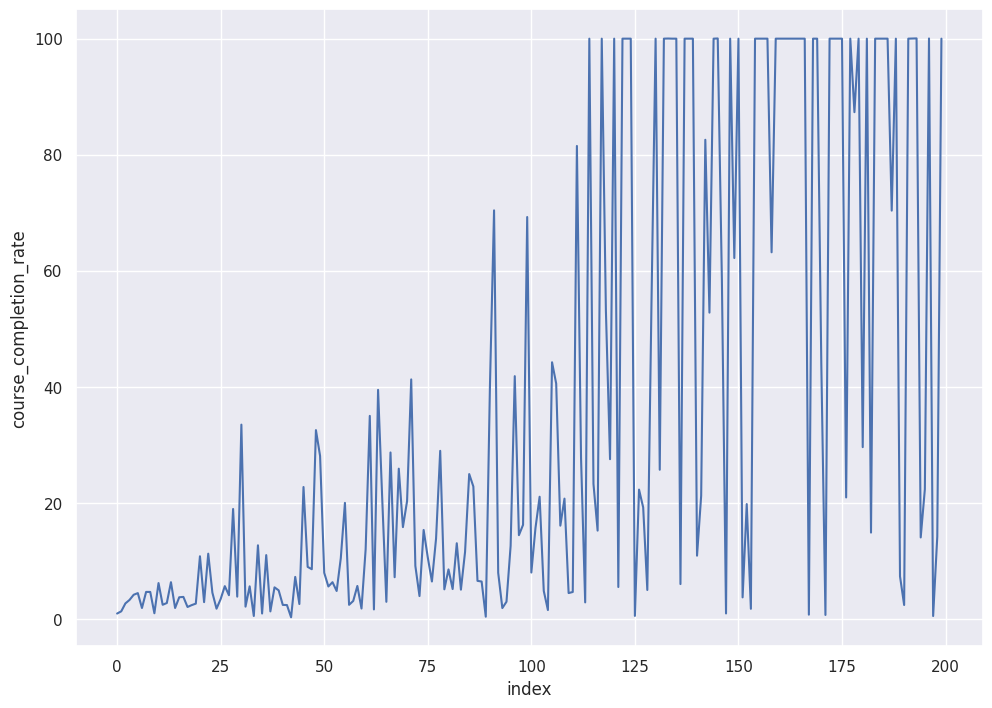

In [141]:
df = pd.read_csv(log_dir1 + "/monitor.csv", header=1).reset_index()
sns.lineplot(df, x='index', y='course_completion_rate')
# sns.lineplot(df, x='index', y='l')

In [41]:
import os
os.environ["DISPLAY"] = ":2"
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('VistaEnv.py'))))
from VistaEnv import VistaEnv
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('CustomCNN.py'))))
from CustomCNN import CustomCNN
import copy
import time

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor, VecFrameStack
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes

import torch

device = ("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device(device)
print(f"Using {device} device")

2024-05-13 21:05:25,338::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it


Using cuda:1 device


2024-05-13 21:06:06,065::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2024-05-13 21:06:06,301::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2024-05-13 21:06:06,577::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2024-05-13 21:06:06,862::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2024-05-13 21:06:10,327::WARNING::[vista.entities.sensors.Camera.reset] No flow data


(array([[[22, 22, 23, ..., 22, 23, 23],
         [25, 24, 25, ..., 21, 21, 19],
         [27, 25, 26, ..., 20, 18, 16],
         ...,
         [68, 70, 71, ..., 20, 20, 18],
         [72, 71, 69, ..., 20, 20, 18],
         [76, 74, 73, ..., 20, 19, 16]]], dtype=uint8),
 {'out_of_lane': False,
  'exceed_rot': False,
  'distance': 0,
  'agent_done': False,
  'course_completion_rate': 0.0})

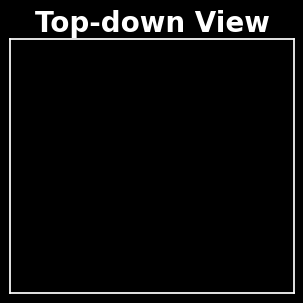

In [45]:
# Initialize the simulator
trace_config = dict(
    road_width=4,
    reset_mode='default',
    master_sensor='camera_front',
)
car_config = dict(
    length=5.,
    width=2.,
    wheel_base=2.78,
    steering_ratio=14.7,
    lookahead_road=True,
)
camera_config = {'type': 'camera',
                 'name': 'camera_front',
                 'rig_path': './RIG.xml',
                 'optical_flow_root': '../data_prep/Super-SloMo/slowmo',
                 'size': (400, 640)}
ego_car_config = copy.deepcopy(car_config)
ego_car_config['lookahead_road'] = True
trace_root = "vista_traces"
trace_path = [
    "20210726-154641_lexus_devens_center", 
    "20210726-155941_lexus_devens_center_reverse", 
    "20210726-184624_lexus_devens_center", 
    "20210726-184956_lexus_devens_center_reverse", 
]
trace_paths = [os.path.join(trace_root, p) for p in trace_path]
display_config = dict(road_buffer_size=1000, )
preprocess_config = {
    "crop_roi": True,
    "resize": True,
    "grayscale": True,
    "binary": False
}
env = VistaEnv(trace_paths = trace_paths, 
       trace_config = trace_config,
       car_config = car_config,
       display_config = display_config,
       preprocess_config = preprocess_config,
       sensors_configs = [camera_config])
env.reset(seed=47)

In [46]:
obs, info = env.reset(seed=47)

2024-05-13 21:06:30,896::WARNING::[vista.entities.sensors.Camera.reset] No flow data


In [47]:
env._world.traces

[<Trace: 20210726-154641_lexus_devens_center>,
 <Trace: 20210726-155941_lexus_devens_center_reverse>,
 <Trace: 20210726-184624_lexus_devens_center>,
 <Trace: 20210726-184956_lexus_devens_center_reverse>]

In [57]:
env._world.agents[0].trace_index

1

In [56]:
env._world.agents[0].frame_number

1343

In [69]:
env._world.traces[0].num_of_frames, env._world.traces[1].num_of_frames, env._world.traces[2].num_of_frames, env._world.traces[3].num_of_frames

(5516, 4734, 5108, 5193)